# Exchange Rate Exploration
1. See what exchange rates exist on fred
2. Download and compile
3. Create a script that can be run (daily?) to update

In [2]:
%load_ext lab_black

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px
import requests
from tqdm import tqdm

from fredapi import Fred

plt.style.use("seaborn-whitegrid")
pd.set_option("max_columns", 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from itertools import cycle

color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## Create Fred Api Object

In [4]:
apifile = open("../014-fred/fred.api", "r")
myapi = apifile.read()
myapi = myapi.strip("\n")
fred = Fred(api_key=myapi)
apifile.close()

# Pulling Exchange Rates from FRED

In [5]:
metadata = fred.search_by_category(94)

In [6]:
dfs = []
for myid in metadata["id"].unique():
    df = fred.get_series(myid)
    break

<AxesSubplot:>

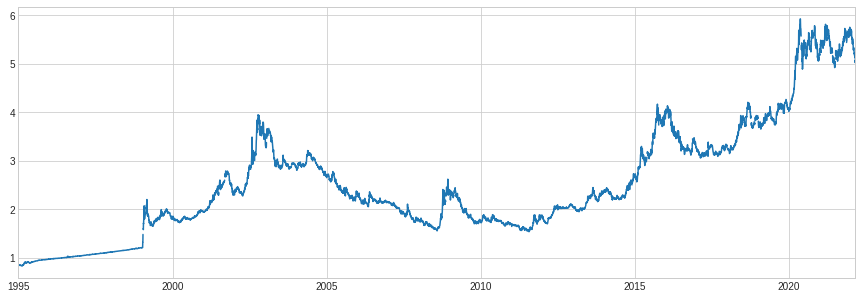

In [7]:
df.plot(figsize=(15, 5))

# Pulling from IMF.org

In [10]:
# Make a dataframe with dates we want to pull
df = pd.DataFrame(pd.date_range("2004-01-01", "2022-03-01"), columns=["dates"])
df["year"] = df["dates"].dt.year
df["month"] = df["dates"].dt.month
df = df.groupby(["year", "month"])["dates"].min().reset_index()

In [11]:
mts = []
for mydate in tqdm(df["dates"]):
    try:
        url = f"https://www.imf.org/external/np/fin/data/rms_mth.aspx?SelectDate={mydate:%Y-%m-%d}&reportType=REP"
        # Read in from the website
        results = pd.read_html(url)
        results[5].columns = results[5].columns.droplevel(0)
        # Table 1
        tempdf = results[5].set_index("Currency").T
        tempdf.index = pd.to_datetime(tempdf.index.str.replace(",", ", "))
        # Table 2
        results[6].columns = results[6].columns.droplevel(0)
        tempdf2 = results[6].set_index("Currency").T
        tempdf2.index = pd.to_datetime(tempdf2.index.str.replace(",", ", "))
        # Concat
        monthall = pd.concat([tempdf, tempdf2])
        mts.append(monthall)
    except:
        print(f"Broke for month {mydate:%Y-%m-%d}")
exchange_data = pd.concat(mts)

100%|█████████████████████████████████████████████████████████| 219/219 [08:33<00:00,  2.35s/it]

Broke for month 2022-03-01


In [25]:
exchange_data.to_parquet("exchange_rates_daily_v1.parquet")

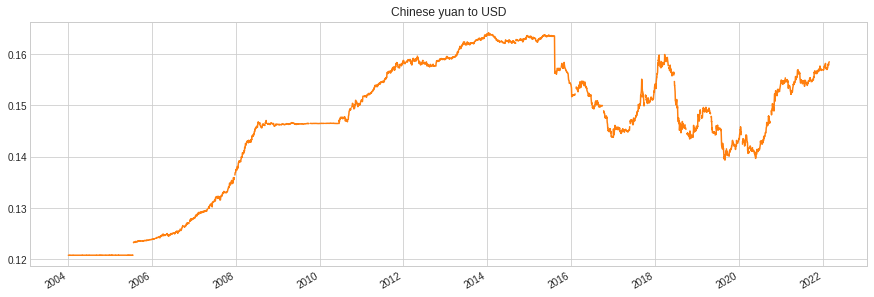

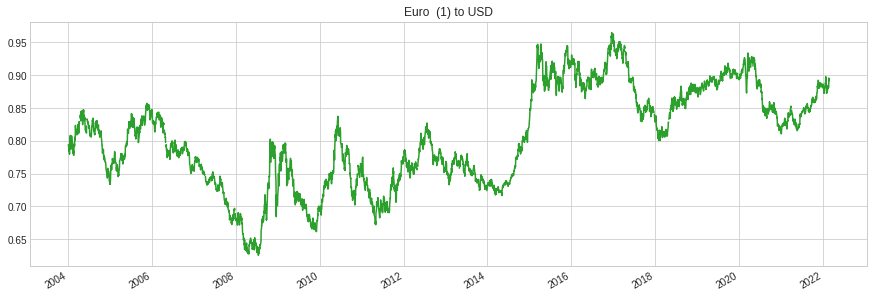

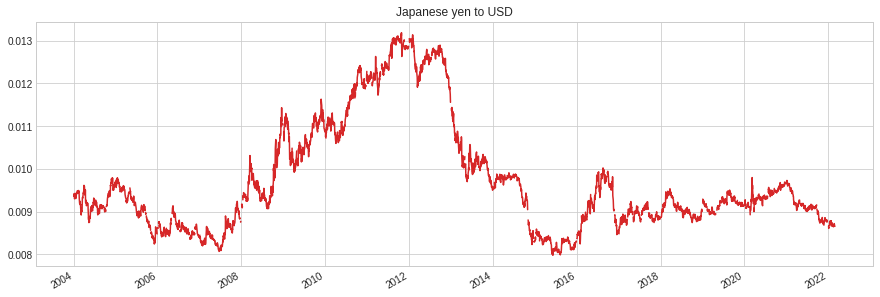

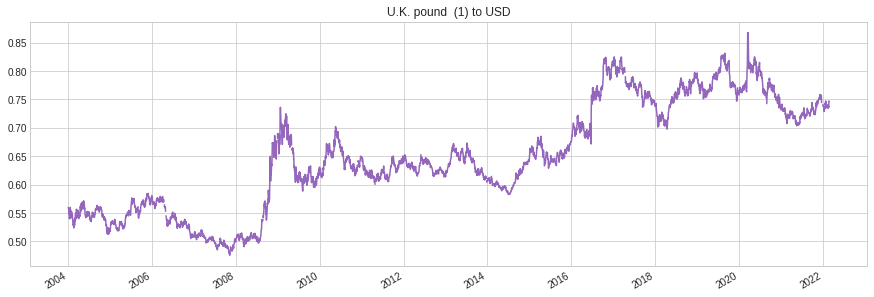

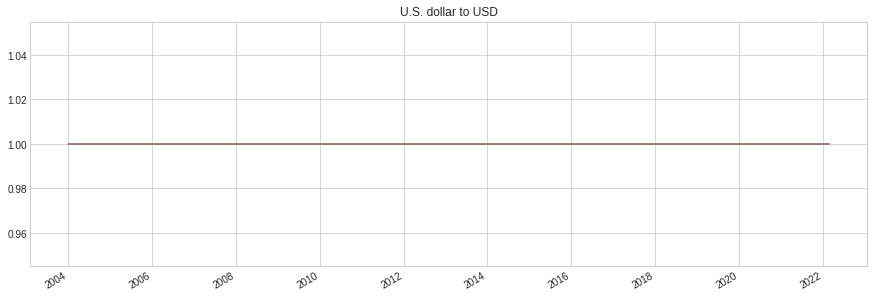

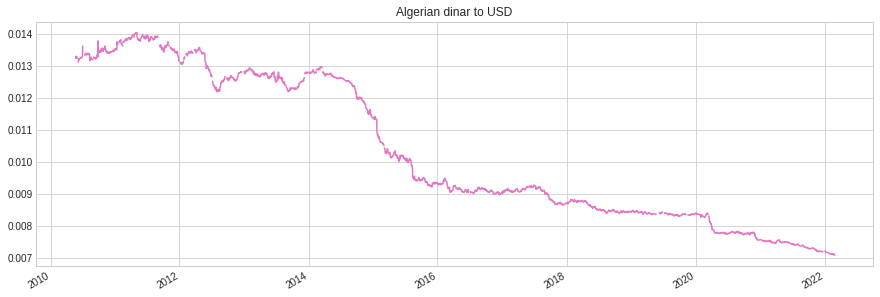

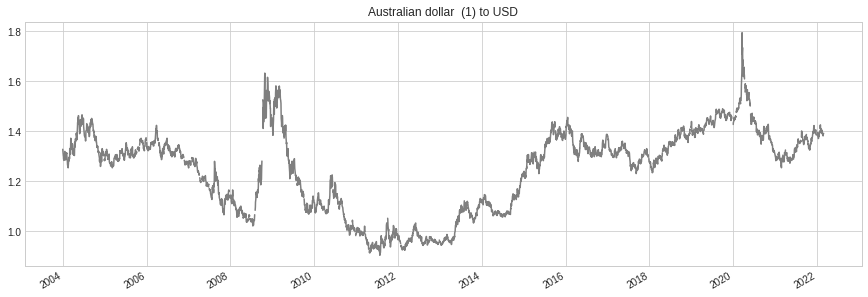

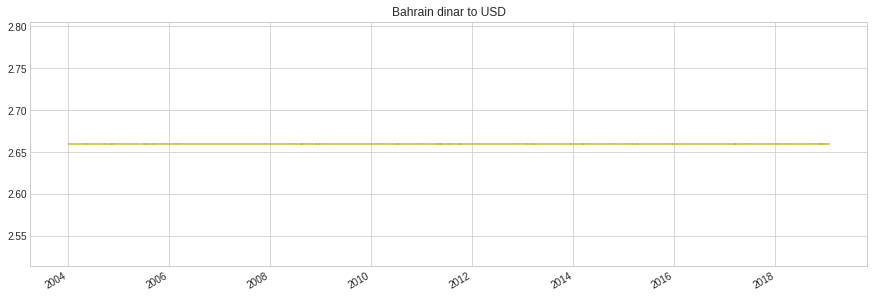

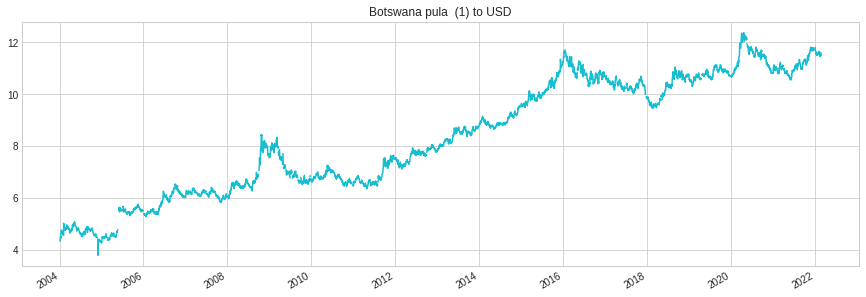

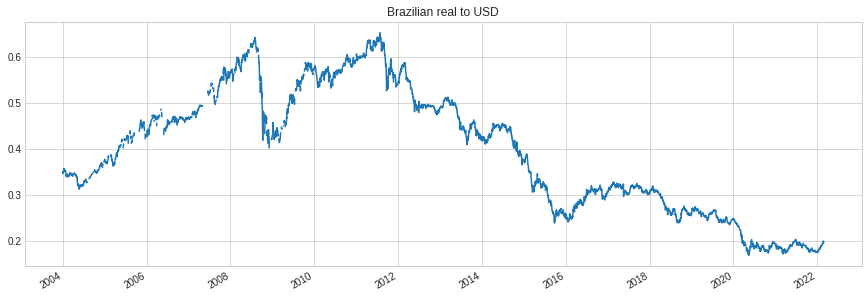

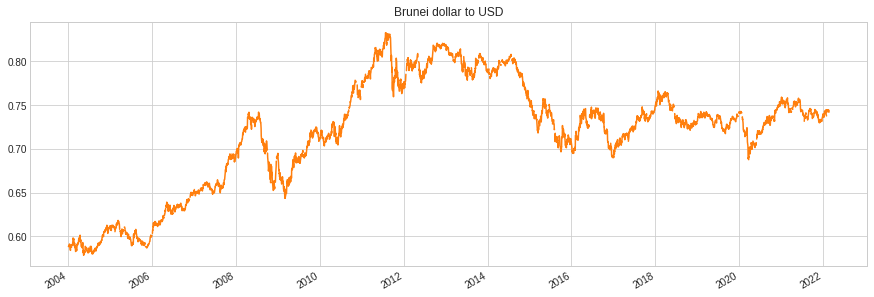

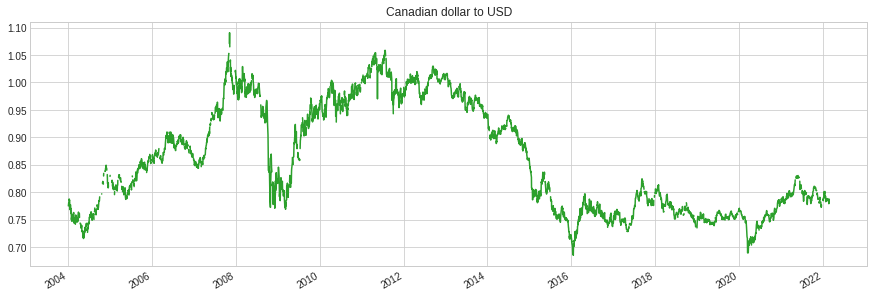

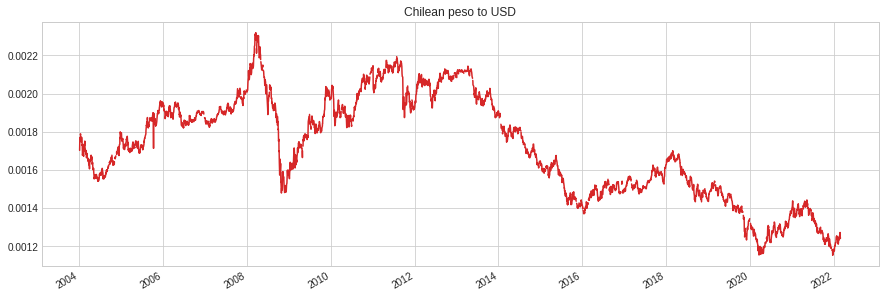

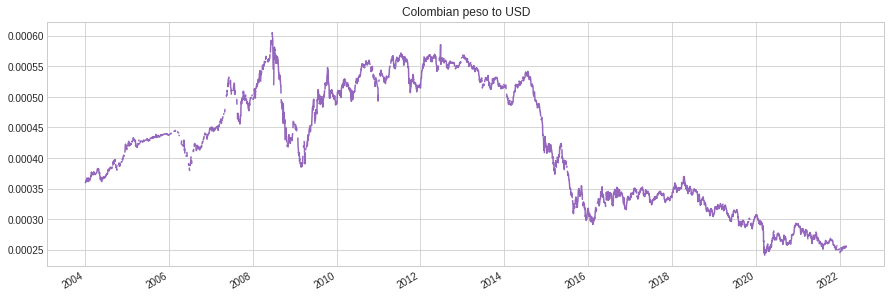

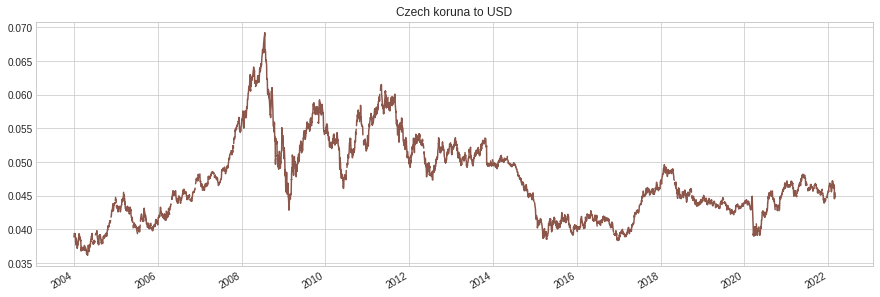

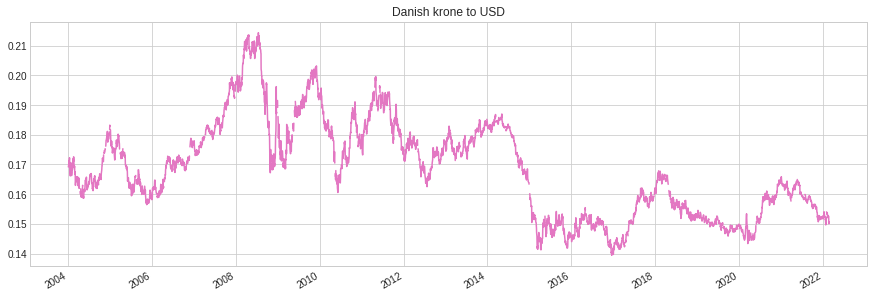

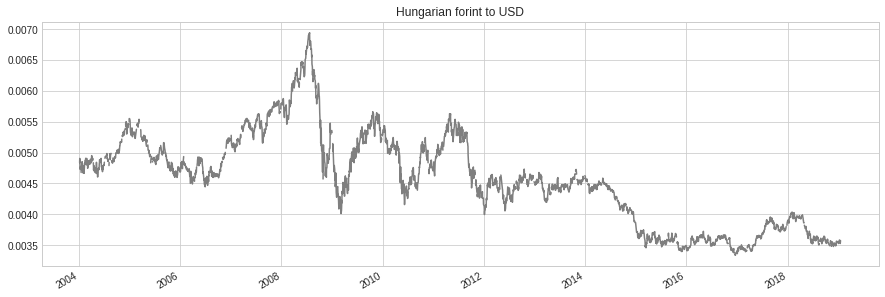

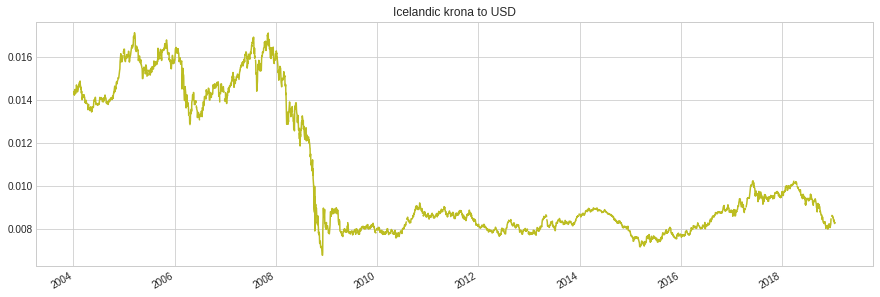

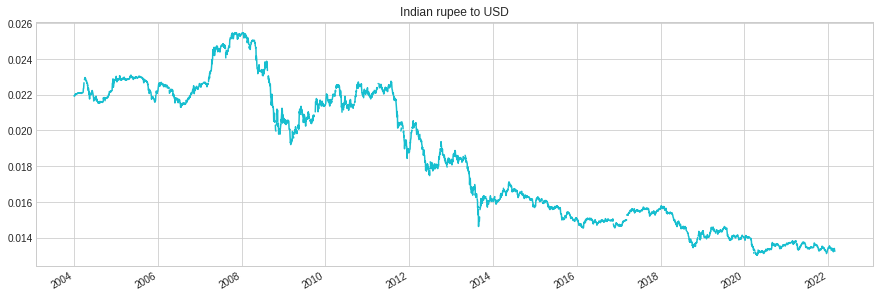

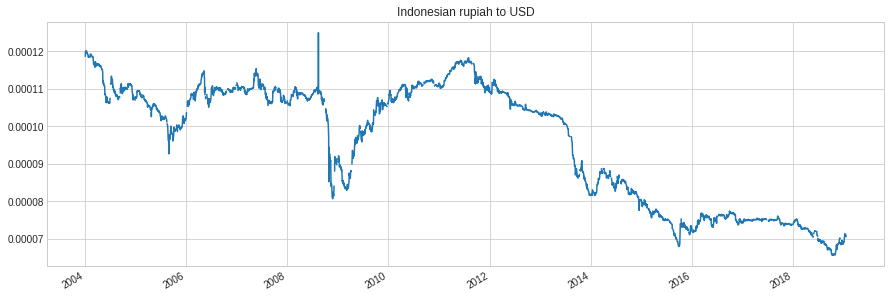

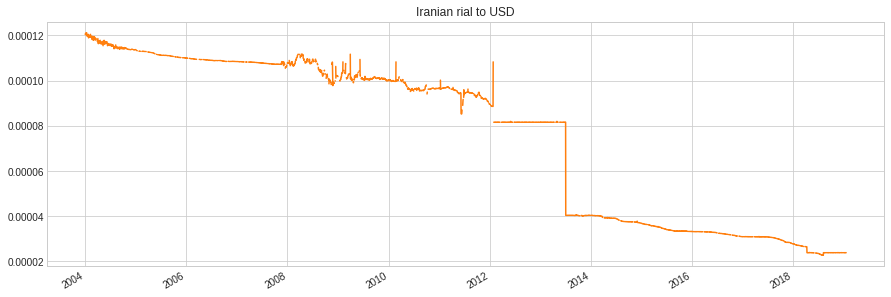

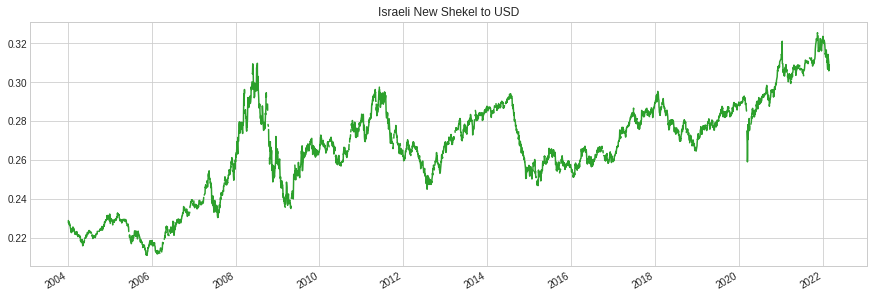

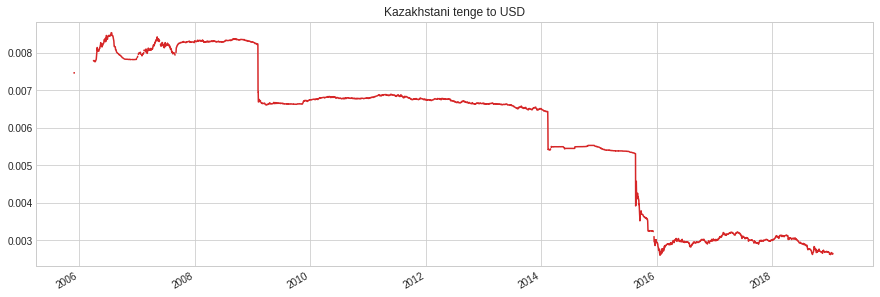

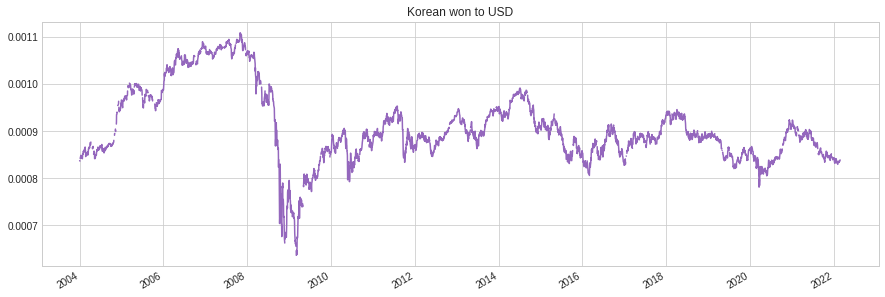

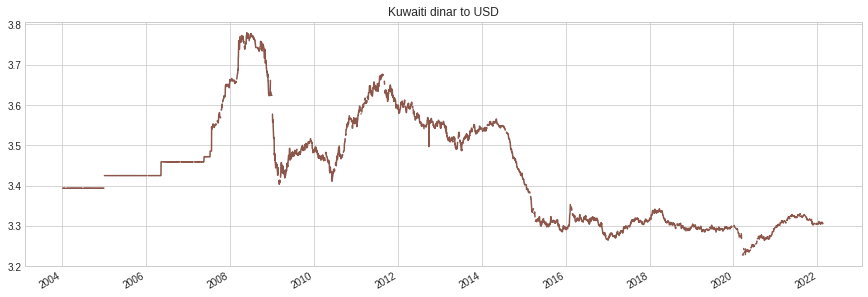

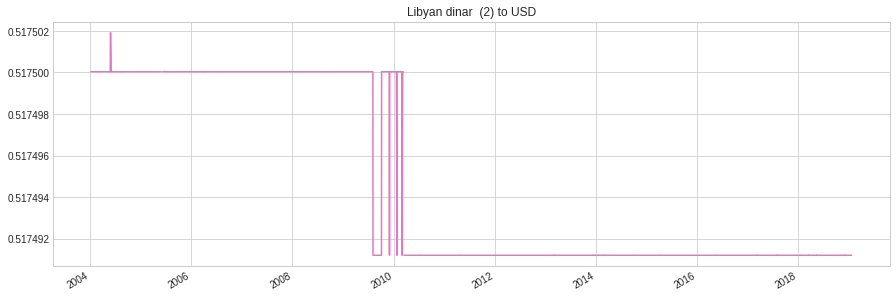

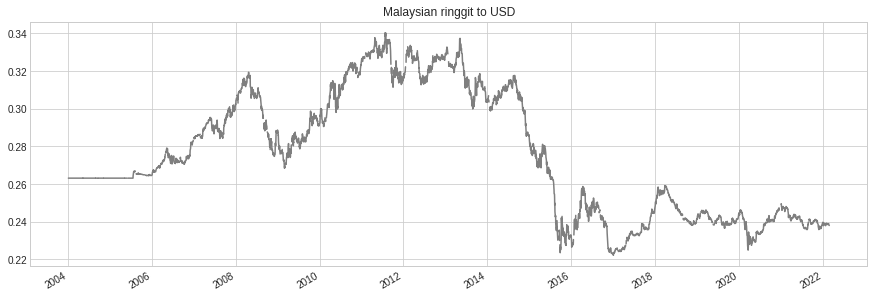

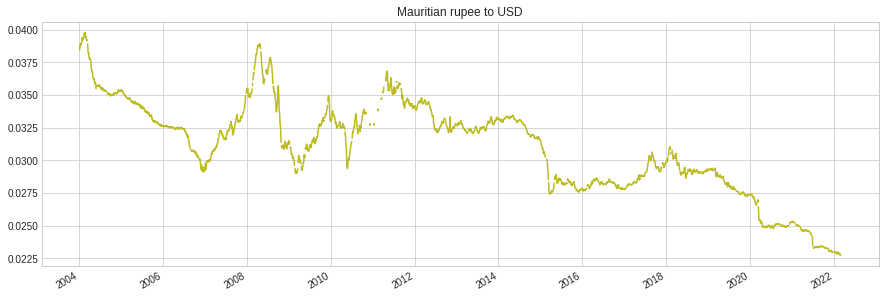

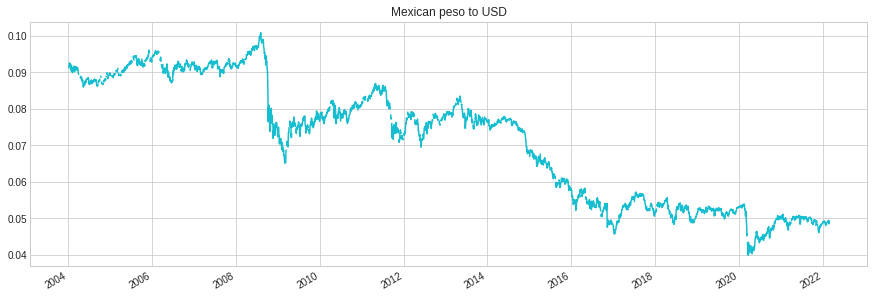

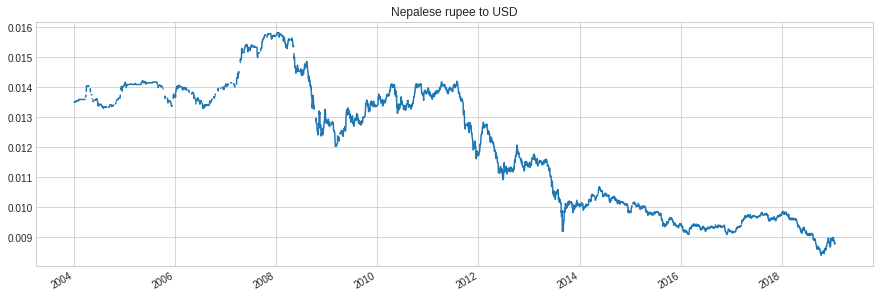

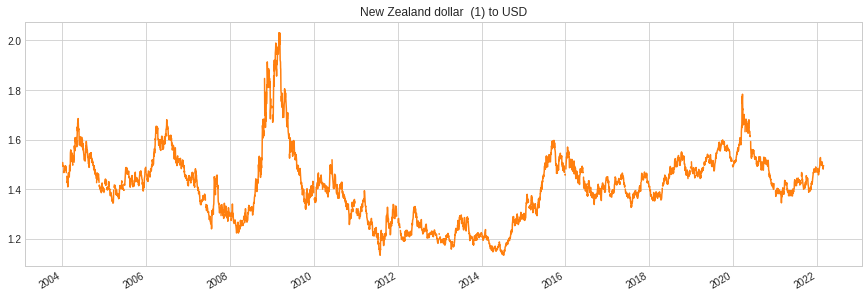

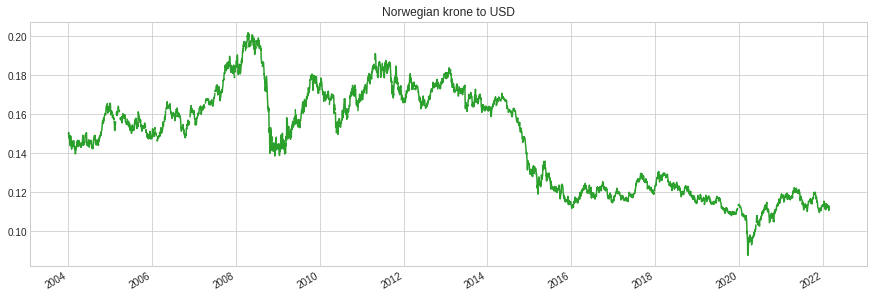

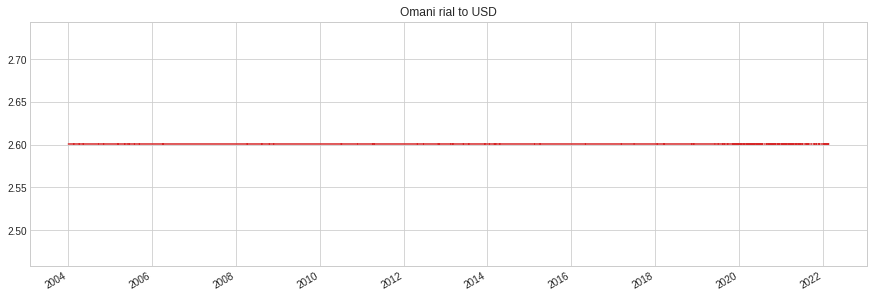

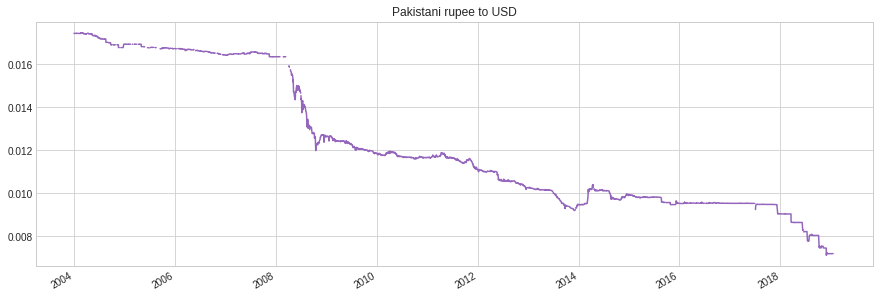

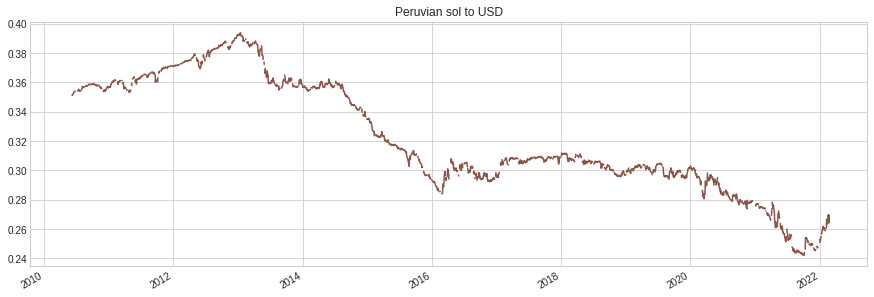

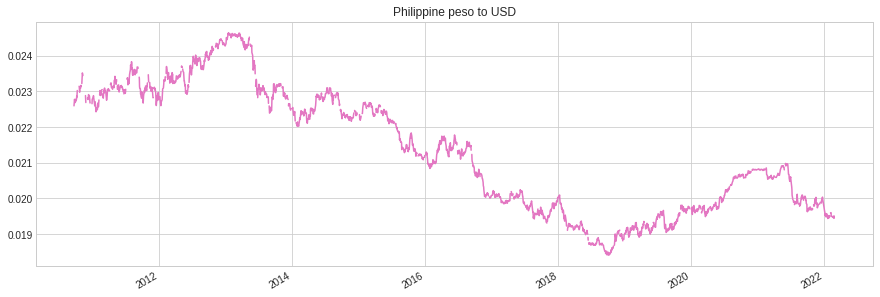

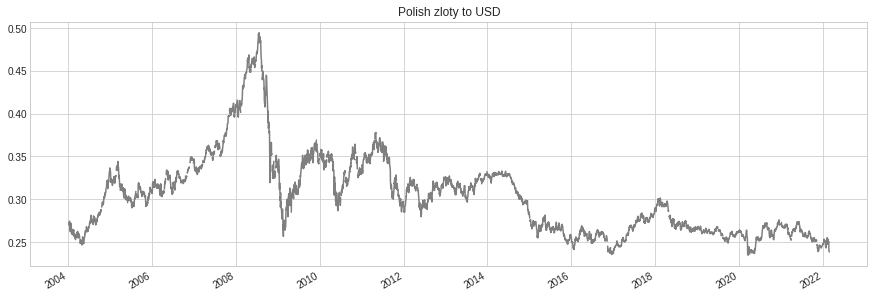

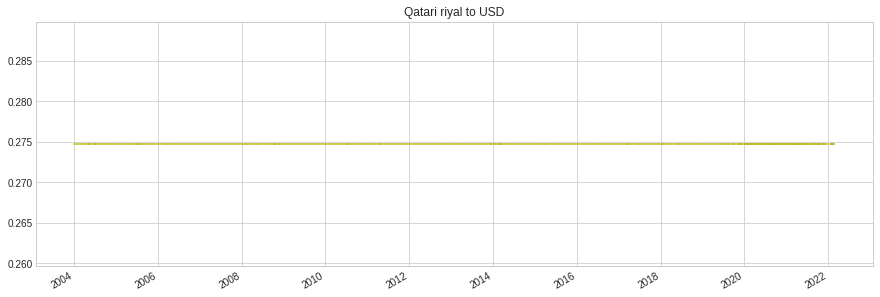

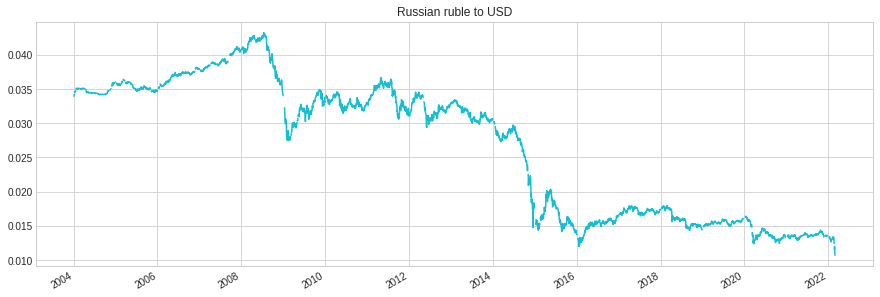

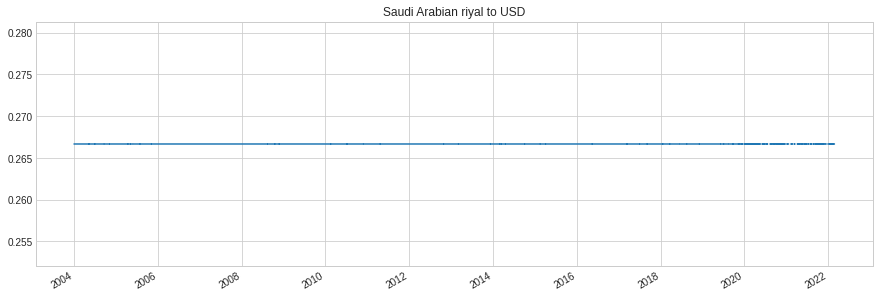

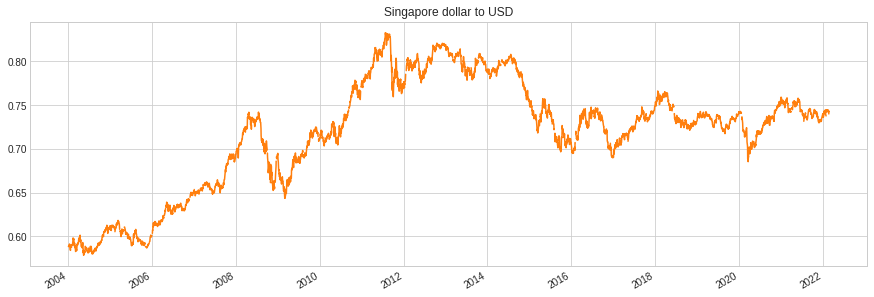

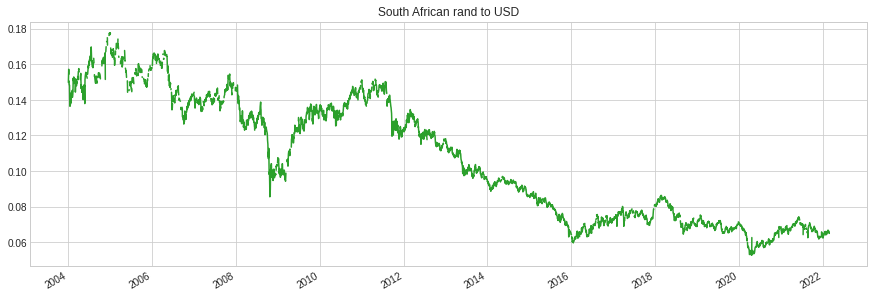

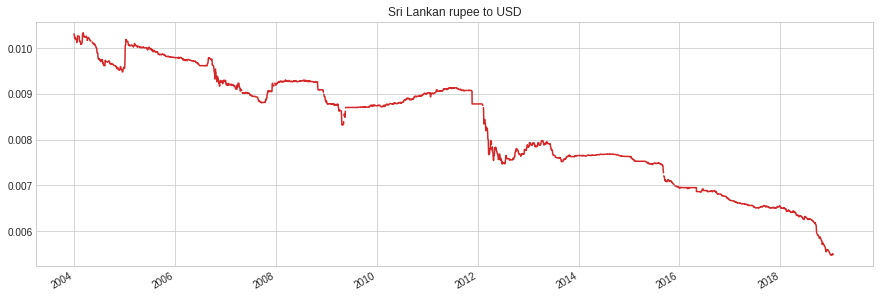

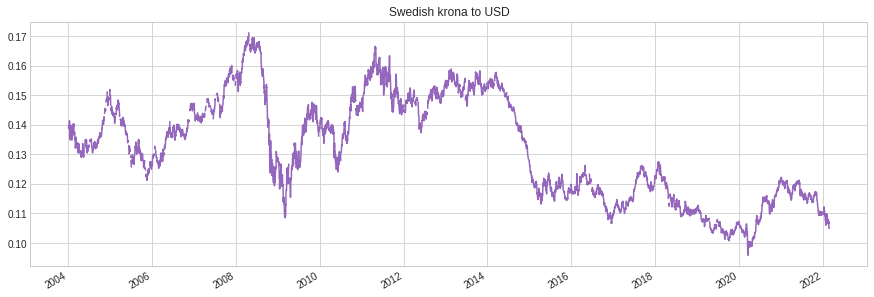

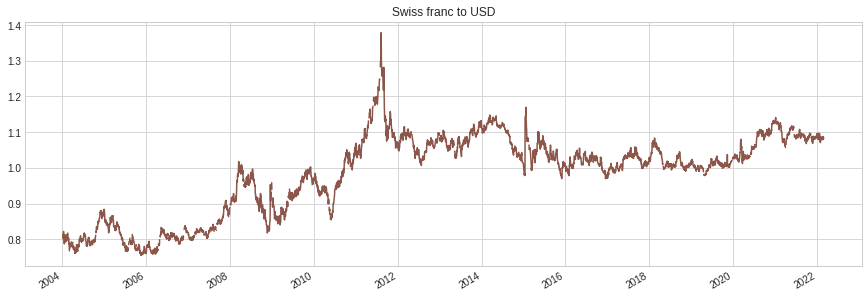

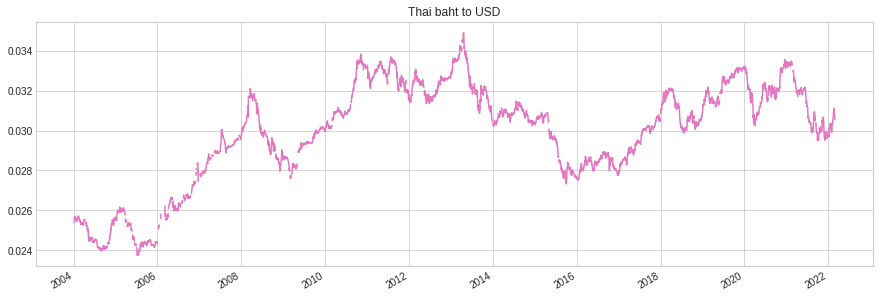

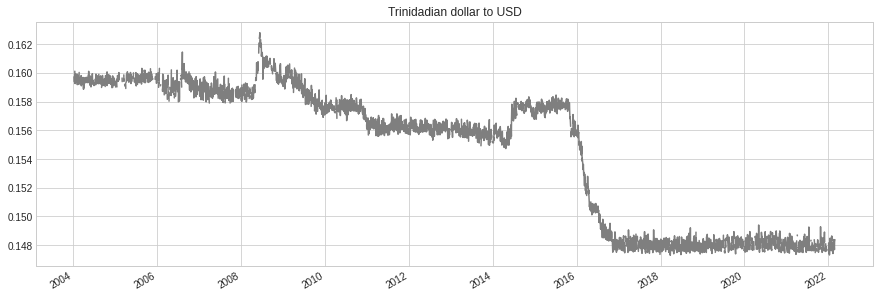

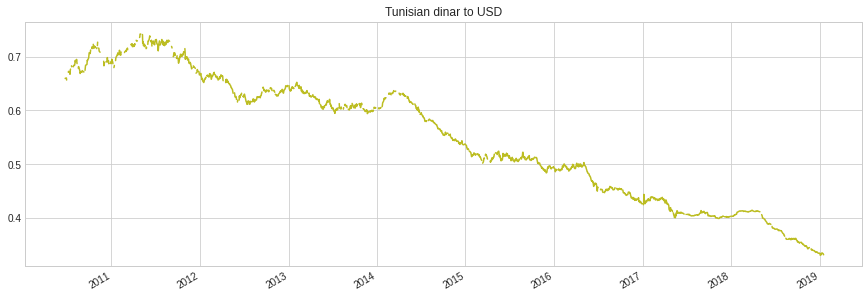

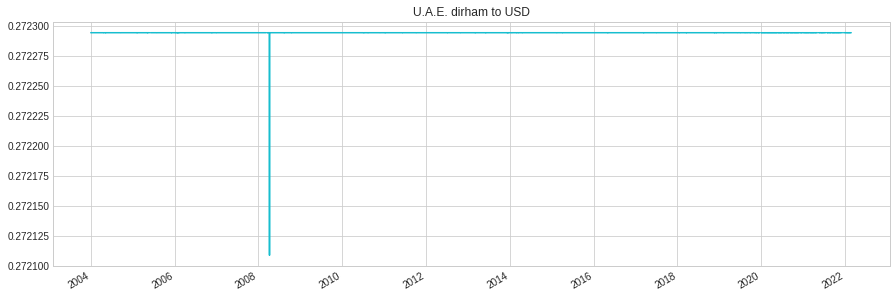

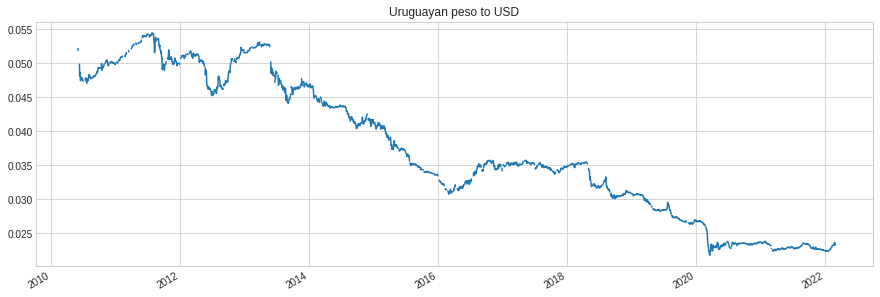

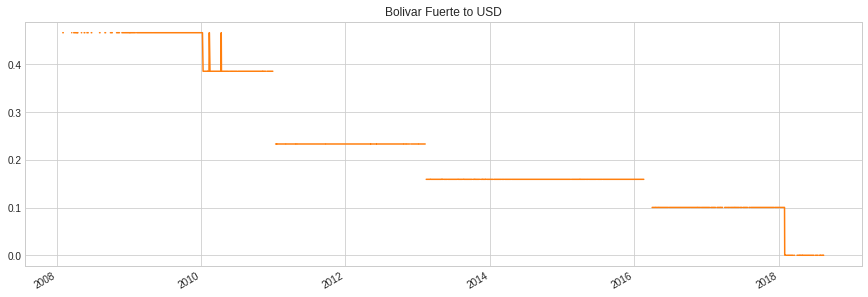

In [29]:
for cur in exchange_data.columns:
    (1 / exchange_data[cur]).plot(
        figsize=(15, 5), title=f"{cur} to USD", color=next(color_cycle)
    )
    plt.show()

In [79]:
import soundfile as sf
from IPython.display import Audio

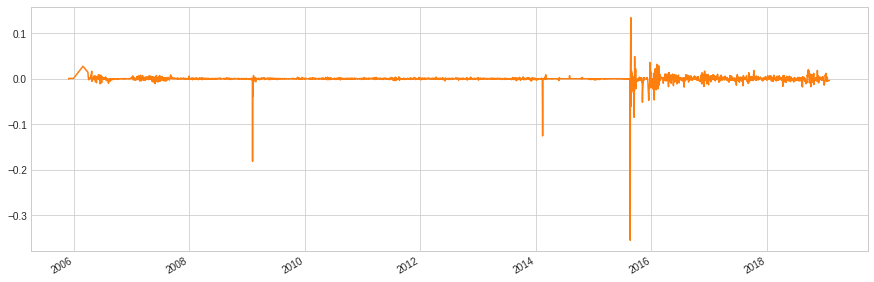

In [82]:
tenge = exchange_data[["Kazakhstani tenge"]].dropna()
tenge["tenge_to_USD"] = 1 / tenge["Kazakhstani tenge"]
tenge["tenge_change"] = tenge["tenge_to_USD"].diff()
tenge["pct_change"] = tenge["tenge_change"] / tenge["tenge_to_USD"]
tenge["pct_change"].plot(figsize=(15, 5), color=next(color_cycle))
data = tenge["pct_change"].dropna().values
samplerate = 3200
sf.write("relative_exchange.wav", data, samplerate, subtype="PCM_24")
Audio("relative_exchange.wav")

In [84]:
exchange_data.columns

Index(['Chinese yuan', 'Euro  (1)', 'Japanese yen', 'U.K. pound  (1)',
       'U.S. dollar', 'Algerian dinar', 'Australian dollar  (1)',
       'Bahrain dinar', 'Botswana pula  (1)', 'Brazilian real',
       'Brunei dollar', 'Canadian dollar', 'Chilean peso', 'Colombian peso',
       'Czech koruna', 'Danish krone', 'Hungarian forint', 'Icelandic krona',
       'Indian rupee', 'Indonesian rupiah', 'Iranian rial',
       'Israeli New Shekel', 'Kazakhstani tenge', 'Korean won',
       'Kuwaiti dinar', 'Libyan dinar  (2)', 'Malaysian ringgit',
       'Mauritian rupee', 'Mexican peso', 'Nepalese rupee',
       'New Zealand dollar  (1)', 'Norwegian krone', 'Omani rial',
       'Pakistani rupee', 'Peruvian sol', 'Philippine peso', 'Polish zloty',
       'Qatari riyal', 'Russian ruble', 'Saudi Arabian riyal',
       'Singapore dollar', 'South African rand', 'Sri Lankan rupee',
       'Swedish krona', 'Swiss franc', 'Thai baht', 'Trinidadian dollar',
       'Tunisian dinar', 'U.A.E. dirham', 'U

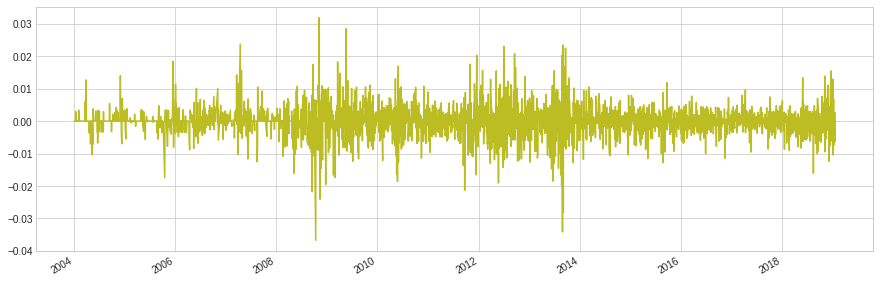

In [91]:
rate = "Nepalese rupee"
tenge = exchange_data[[rate]].dropna()
tenge["tenge_to_USD"] = 1 / tenge[rate]
tenge["tenge_change"] = tenge["tenge_to_USD"].diff()
tenge["pct_change"] = tenge["tenge_change"] / tenge["tenge_to_USD"]
tenge["pct_change"].plot(figsize=(15, 5), color=next(color_cycle))
data = tenge["pct_change"].dropna().values
samplerate = 3200
sf.write("relative_exchange.wav", data, samplerate, subtype="PCM_24")
Audio("relative_exchange.wav")

# Format Dataset

In [29]:
%load_ext lab_black

In [2]:
import pandas as pd
exchange_data = pd.read_parquet('exchange_rates_daily_v1.parquet')

In [27]:
to_usd_df = pd.DataFrame(index=exchange_data.index)
for currency in exchange_data.columns:
    ex_rate_col = currency.lower().replace('  (1)','').replace(' ','_') \
        .replace('.','') + '_to_usd'
    to_usd_df[ex_rate_col] = 1 / exchange_data[currency]
to_usd_df = to_usd_df.reset_index().rename(columns={'index':'date'})

<AxesSubplot:xlabel='date'>

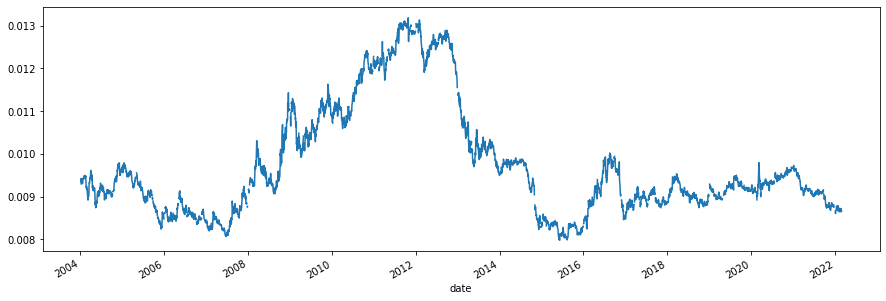

In [30]:
to_usd_df.set_index("date")["japanese_yen_to_usd"].plot(figsize=(15, 5))

<AxesSubplot:xlabel='date'>

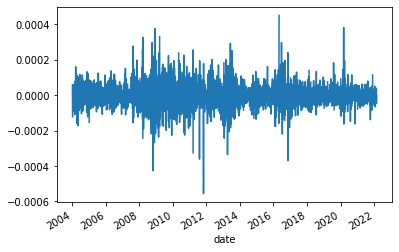

In [35]:
to_usd_df.set_index("date")["japanese_yen_to_usd"].diff().plot()

In [39]:
to_usd_df["russian_ruble_to_usd_pct_change"] = (
    to_usd_df["russian_ruble_to_usd"].diff() / to_usd_df["russian_ruble_to_usd"]
)

<AxesSubplot:xlabel='date'>

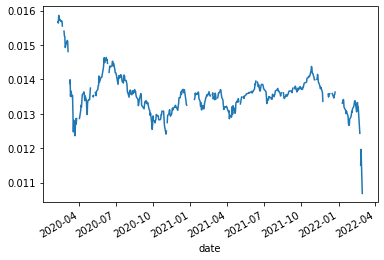

In [47]:
to_usd_df.set_index("date")["russian_ruble_to_usd"].tail(500).plot()

<AxesSubplot:xlabel='date'>

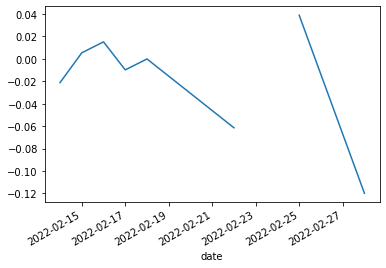

In [44]:
to_usd_df.set_index("date")["russian_ruble_to_usd_pct_change"].tail(10).plot()